In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.base import clone
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


In [16]:

def load_data():
    df = pd.read_csv('Data/stroke_dataset.csv')
    
    categorical = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    numerical = ['avg_glucose_level', 'bmi', 'age']
    y = df['stroke']
    X = df.drop('stroke', axis=1)
    
    return X, y, categorical, numerical

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = []
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
    
    final_model = clone(model)
    final_model.fit(X, y)
    
    return np.array(scores), final_model

def get_models():
    models, names = list(), list()
    models.append(XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    names.append('XGB')
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    return models, names

def plot_results(results, names):
    plt.boxplot(results, labels=names, showmeans=True)
    plt.title('Model Performance Comparison')
    plt.ylabel('ROC AUC')
    plt.show()



In [17]:

X, y, categorical, numerical = load_data()
print(f"Data shape: {X.shape}, {y.shape}")

transformer = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

models, names = get_models()
results = []





Data shape: (4981, 10), (4981,)



XGB Results:
Mean ROC AUC: 0.774 (+/- 0.069)

Confusion Matrix:
[[4723   10]
 [  64  184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4733
           1       0.95      0.74      0.83       248

    accuracy                           0.99      4981
   macro avg       0.97      0.87      0.91      4981
weighted avg       0.98      0.99      0.98      4981


LDA Results:
Mean ROC AUC: 0.838 (+/- 0.055)

Confusion Matrix:
[[3408 1325]
 [  43  205]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      4733
           1       0.13      0.83      0.23       248

    accuracy                           0.73      4981
   macro avg       0.56      0.77      0.53      4981
weighted avg       0.95      0.73      0.80      4981


RF Results:
Mean ROC AUC: 0.773 (+/- 0.047)

Confusion Matrix:
[[4733    0]
 [   0  248]]

Classification Report:

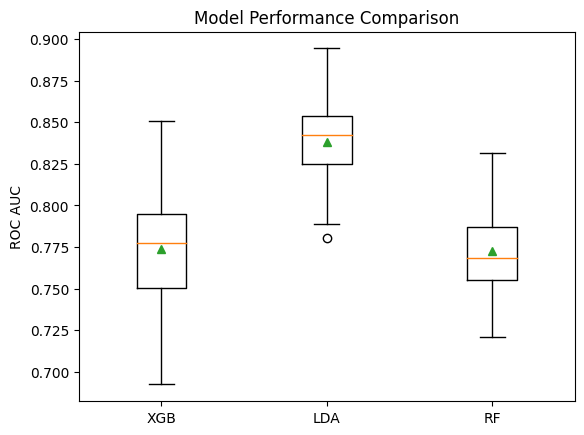

In [18]:
for model, name in zip(models, names):
    pipeline = Pipeline(steps=[
        ('t', transformer),
        ('p', PowerTransformer(method='yeo-johnson', standardize=True)),
        ('over', SMOTE()),
        ('m', model)
    ])

    scores, final_model = evaluate_model(X, y, pipeline)
    results.append(scores)
    
    print(f"\n{name} Results:")
    print(f"Mean ROC AUC: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")
    
    # Generate predictions on the entire dataset for confusion matrix and classification report
    y_pred = final_model.predict(X)
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

plot_results(results, names)

# SIN DATOS SINTETICOS EN TESTING

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.base import clone
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


In [21]:

def load_data():
    df = pd.read_csv('Data/stroke_dataset.csv')
    
    categorical = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    numerical = ['avg_glucose_level', 'bmi', 'age']
    y = df['stroke']
    X = df.drop('stroke', axis=1)
    
    return X, y, categorical, numerical

def evaluate_model(X, y, model, transformer):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = []
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Apply preprocessing
        X_train_processed = transformer.fit_transform(X_train)
        X_test_processed = transformer.transform(X_test)
        
        # Apply SMOTE only to training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
        
        # Clone and fit the model
        model_clone = clone(model)
        model_clone.fit(X_train_resampled, y_train_resampled)
        
        # Predict on test data (without SMOTE)
        y_pred = model_clone.predict_proba(X_test_processed)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
    
    # Fit final model on entire dataset
    X_processed = transformer.fit_transform(X)
    X_resampled, y_resampled = smote.fit_resample(X_processed, y)
    final_model = clone(model)
    final_model.fit(X_resampled, y_resampled)
    
    return np.array(scores), final_model

def get_models():
    models, names = list(), list()
    models.append(XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    names.append('XGB')
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    return models, names

def plot_results(results, names):
    plt.figure(figsize=(10, 6))
    plt.boxplot(results, labels=names, showmeans=True)
    plt.title('Model Performance Comparison')
    plt.ylabel('ROC AUC')
    plt.show()

def calculate_overfitting(model, transformer, X_train, y_train, X_test, y_test):
    # Preprocess data
    X_train_processed = transformer.fit_transform(X_train)
    X_test_processed = transformer.transform(X_test)
    
    # Apply SMOTE only to training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    
    # Fit model on resampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Calculate AUC on training and test data
    train_pred = model.predict_proba(X_train_resampled)[:, 1]
    test_pred = model.predict_proba(X_test_processed)[:, 1]
    
    train_auc = roc_auc_score(y_train_resampled, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    overfitting_percentage = ((train_auc - test_auc) / train_auc) * 100
    
    return train_auc, test_auc, overfitting_percentage



Data shape: (4981, 10), (4981,)

XGB Results:
Mean ROC AUC: 0.773 (+/- 0.071)

Confusion Matrix:
[[4725    8]
 [  37  211]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4733
           1       0.96      0.85      0.90       248

    accuracy                           0.99      4981
   macro avg       0.98      0.92      0.95      4981
weighted avg       0.99      0.99      0.99      4981


Overfitting Analysis:
Train AUC: 1.000
Test AUC: 0.776
Overfitting Percentage: 22.38%

LDA Results:
Mean ROC AUC: 0.837 (+/- 0.056)

Confusion Matrix:
[[3400 1333]
 [  45  203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      4733
           1       0.13      0.82      0.23       248

    accuracy                           0.72      4981
   macro avg       0.56      0.77      0.53      4981
weighted avg       0.94      0.72      0.80      4

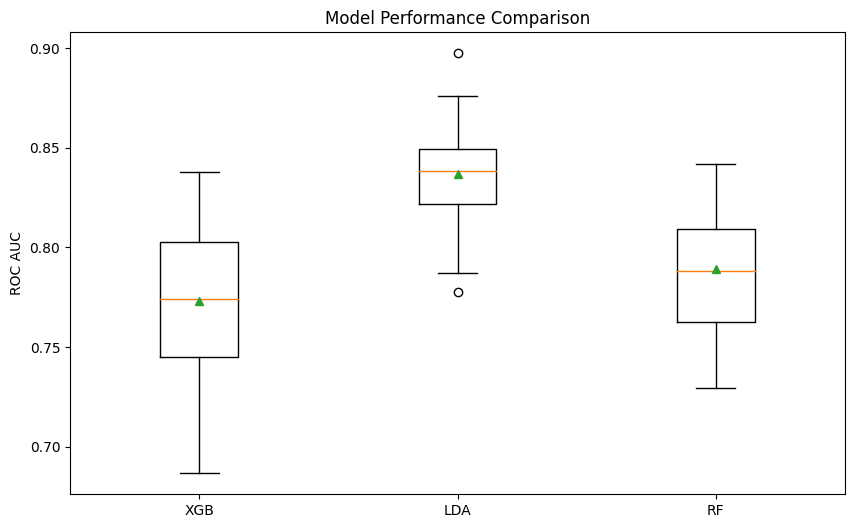

In [22]:
 X, y, categorical, numerical = load_data()
print(f"Data shape: {X.shape}, {y.shape}")

transformer = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', PowerTransformer(method='yeo-johnson', standardize=True))
    ]), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

models, names = get_models()
results = []

# Split data for overfitting calculation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for model, name in zip(models, names):
    scores, final_model = evaluate_model(X, y, model, transformer)
    results.append(scores)
    
    print(f"\n{name} Results:")
    print(f"Mean ROC AUC: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")
    
    # Generate predictions on the entire dataset for confusion matrix and classification report
    X_processed = transformer.transform(X)
    y_pred = final_model.predict(X_processed)
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    # Calculate and print overfitting percentage
    train_auc, test_auc, overfitting_percentage = calculate_overfitting(clone(model), transformer, X_train, y_train, X_test, y_test)
    print(f"\nOverfitting Analysis:")
    print(f"Train AUC: {train_auc:.3f}")
    print(f"Test AUC: {test_auc:.3f}")
    print(f"Overfitting Percentage: {overfitting_percentage:.2f}%")

plot_results(results, names)
